## Dependencies

In [105]:
import pandas as pd
import numpy as np
import math as mt

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

## Circle

$$area = \pi r^2$$
$$perimeter = 2 \pi r$$
$$area = (\frac{perimeter}{2})^2 \div \pi$$

In [106]:
# Set seed
rng = np.random.default_rng(seed=0)

radius_train = rng.integers(low=1, high=100, size=8000)
radius_test = rng.integers(low=1, high=100, size=2000)

In [108]:
# Define ciricle to store radius, perimeter, and area
circle_train = pd.DataFrame({'r': radius_train})
# perimeter of circle = 2 * pi * r
circle_train['perimeter'] = 2 * radius_train * mt.pi
# area of circle = pi * r^2
circle_train['area'] = radius_train**2 * mt.pi
# add irrelevant column
circle_train['irr_col'] = rng.integers(low=0, high=100, size=8000)
# add pi
circle_train['pi'] = [mt.pi] * 8000

# Define ciricle to store radius, perimeter, and area
circle_test = pd.DataFrame({'r': radius_test})
# perimeter of circle = 2 * pi * r
circle_test['perimeter'] = 2 * radius_test * mt.pi
# area of circle = pi * r^2
circle_test['area'] = radius_test**2 * mt.pi
# add irrelevant column
circle_test['irr_col'] = rng.integers(low=0, high=100, size=2000)
# add pi
circle_test['pi'] = [mt.pi] * 2000

circle_train.head()

,r,perimeter,area,irr_col,pi
0,85,534.070751,22698.006922,21,3.141593
1,64,402.123860,12867.963509,56,3.141593
2,51,320.442451,8171.282492,48,3.141593
3,27,169.646003,2290.221044,96,3.141593
4,31,194.778745,3019.070540,42,3.141593


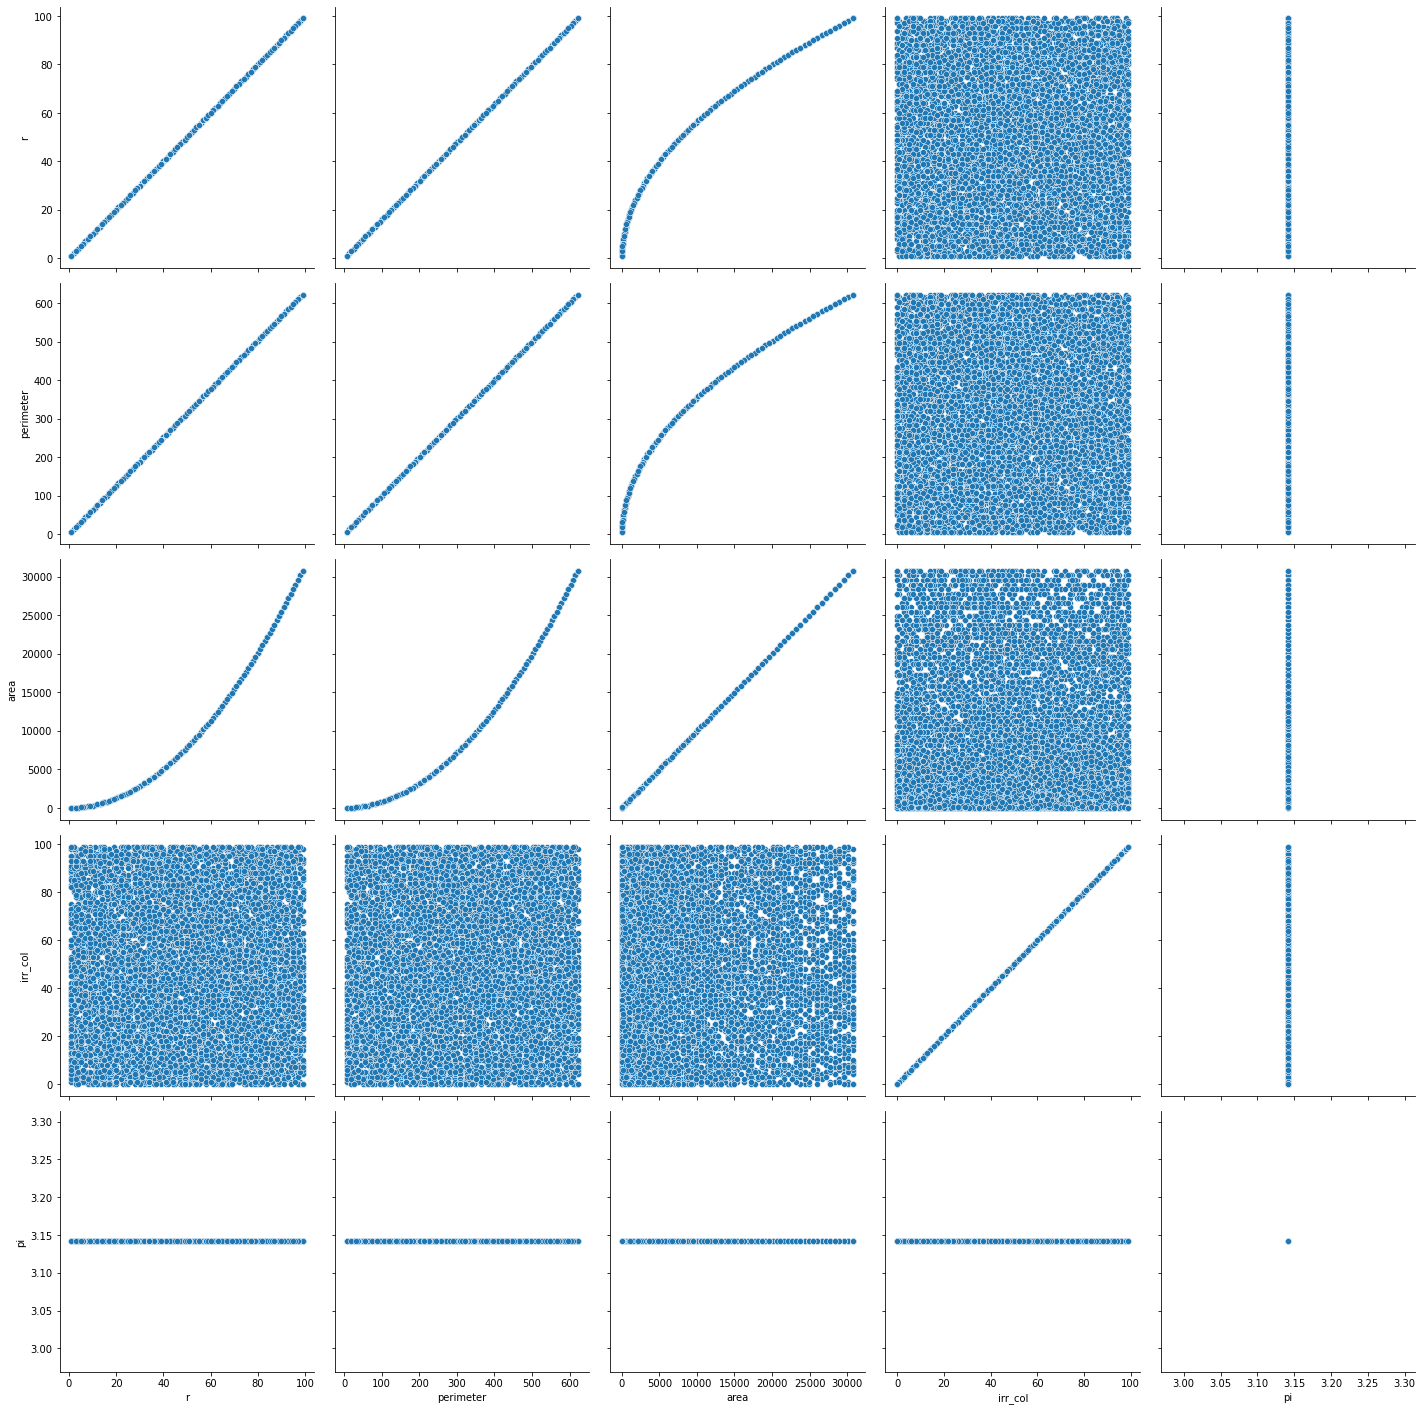

In [109]:
g = sns.PairGrid(circle_train, height=4)
g.map(sns.scatterplot)

In [110]:
X_train = circle_train.copy()
y_train = X_train.pop('area')

In [111]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [112]:
pca, X_pca, loadings = apply_pca(X_train)
loadings

,PC1,PC2,PC3,PC4
r,7.070536e-01,-8.673862e-03,-6.948411e-01,-1.311327e-01
perimeter,7.070536e-01,-8.673862e-03,6.948411e-01,1.311327e-01
irr_col,1.226669e-02,9.999248e-01,3.469447e-18,8.673617e-19
pi,2.245451e-33,1.119020e-31,1.854496e-01,-9.826538e-01


In [113]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [117]:
%%time

# Review the MI score from the raw numerical data
num_mi_scores = pd.DataFrame(make_mi_scores(X_train, y_train))

num_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: user 321 ms, sys: 4.27 ms, total: 325 ms
Wall time: 324 ms


,MI Scores
perimeter,4.597979
r,4.594437
pi,0.002688
irr_col,0.000000


In [118]:
num_mi_scores = pd.DataFrame(make_mi_scores(X_pca, y_train))

num_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,MI Scores
PC1,4.591465
PC4,3.038735
PC3,3.037307
PC2,0.204874


---

## Modeling

In [137]:
def test_model(model, cols):
    # Fit the model
    model.fit(X_train[cols], y_train)

    # Prediction
    pred = model.predict(X_test[cols])

    # Calculate RMSE
    print(f'Features: {cols}')
    print(f"RMSE: {float(mt.sqrt(mean_squared_error(y_test, pred)))}")
    print()

---

### XGBoost - Predict area

In [138]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [132]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [139]:
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi'])
test_model(model, cols=['r', 'perimeter', 'pi'])
test_model(model, cols=['r', 'pi'])
test_model(model, cols=['r'])
test_model(model, cols=['perimeter', 'pi'])
test_model(model, cols=['irr_col'])
test_model(model, cols=['pi'])

Features: ['r', 'perimeter', 'irr_col', 'pi']
RMSE: 1.2031746006441546

Features: ['r', 'perimeter', 'pi']
RMSE: 0.18662965421505567

Features: ['r', 'pi']
RMSE: 0.48181033322206646

Features: ['r']
RMSE: 0.042235383325839815

Features: ['perimeter', 'pi']
RMSE: 0.48181033322206646

Features: ['irr_col']
RMSE: 9535.493352165098

Features: ['pi']
RMSE: 9468.92410560133



In [144]:
# All columns / r
1.2031746006441546 / 0.042235383325839815

28.48736073641947

---

### XGBoost - Predict perimeter

In [140]:
X_train = circle_train.copy()
y_train = X_train.pop('perimeter')
X_test = circle_test.copy()
y_test = X_test.pop('perimeter')

In [141]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [142]:
test_model(model, cols=['r', 'area', 'irr_col', 'pi'])
test_model(model, cols=['r', 'area', 'pi'])
test_model(model, cols=['r', 'pi'])
test_model(model, cols=['r'])
test_model(model, cols=['area', 'pi'])
test_model(model, cols=['irr_col'])
test_model(model, cols=['pi'])

Features: ['r', 'area', 'irr_col', 'pi']
RMSE: 0.02044363812128194

Features: ['r', 'area', 'pi']
RMSE: 0.0035419185844355753

Features: ['r', 'pi']
RMSE: 0.016603643383992107

Features: ['r']
RMSE: 0.001146936150461565

Features: ['area', 'pi']
RMSE: 0.016603643383992107

Features: ['irr_col']
RMSE: 183.8948484762073

Features: ['pi']
RMSE: 182.51558117078227



In [143]:
# All columns / r
0.02044363812128194 / 0.001146936150461565

17.824565136476643

---

### Linear Regression - Predict area

In [145]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [146]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [147]:
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi'])
test_model(model, cols=['r', 'perimeter', 'pi'])
test_model(model, cols=['r', 'pi'])
test_model(model, cols=['r'])
test_model(model, cols=['perimeter', 'pi'])
test_model(model, cols=['irr_col'])
test_model(model, cols=['pi'])

Features: ['r', 'perimeter', 'irr_col', 'pi']
RMSE: 2293.684157524477

Features: ['r', 'perimeter', 'pi']
RMSE: 2293.8025346382065

Features: ['r', 'pi']
RMSE: 2293.802534638207

Features: ['r']
RMSE: 2293.802534638207

Features: ['perimeter', 'pi']
RMSE: 2293.8025346382065

Features: ['irr_col']
RMSE: 9471.836590495375

Features: ['pi']
RMSE: 9468.923972659888



In [148]:
# All columns / r
2293.684157524477 / 2293.802534638207

0.9999483926310385

---

### Linear Regression - Predict perimeter

In [149]:
X_train = circle_train.copy()
y_train = X_train.pop('perimeter')
X_test = circle_test.copy()
y_test = X_test.pop('perimeter')

In [150]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [151]:
test_model(model, cols=['r', 'area', 'irr_col', 'pi'])
test_model(model, cols=['r', 'area', 'pi'])
test_model(model, cols=['r', 'pi'])
test_model(model, cols=['r'])
test_model(model, cols=['area', 'pi'])
test_model(model, cols=['irr_col'])
test_model(model, cols=['pi'])

Features: ['r', 'area', 'irr_col', 'pi']
RMSE: 3.1320595957721257e-13

Features: ['r', 'area', 'pi']
RMSE: 1.2592775647750621e-13

Features: ['r', 'pi']
RMSE: 1.3203214050047377e-13

Features: ['r']
RMSE: 1.3203214050047377e-13

Features: ['area', 'pi']
RMSE: 44.18970154684245

Features: ['irr_col']
RMSE: 182.59021942032504

Features: ['pi']
RMSE: 182.51557728387417



In [152]:
# All columns / r
3.1320595957721257e-13 / 1.3203214050047377e-13

2.3721948185494175

---

## Test PCA

---

### XGBoost - Predict area

In [98]:
from sklearn.model_selection import train_test_split

def test_pca(model):
    # Fit the model
    model.fit(X_train_pca, y_train)

    # Prediction
    pred = model.predict(X_test_pca)

    # Calculate RMSE
    return mt.sqrt(mean_squared_error(y_test, pred))

In [99]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [100]:
pca, X_train_pca, loadings = apply_pca(X_train)
pca, X_test_pca, loadings = apply_pca(X_test)

In [101]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [102]:
# using all columns for prediction
test_pca(model)

17666.484500949457

In [15]:
# using r and perimeter for prediction
test_model(model, cols=['r', 'perimeter'])

RMSE: 0.042235383325839815


In [16]:
# using r for prediction
test_model(model, cols=['r'])

RMSE: 0.042235383325839815


In [17]:
# using perimeter for prediction
test_model(model, cols=['perimeter'])

RMSE: 0.042235383325839815


In [18]:
# using irr_col for prediction
test_model(model, cols=['irr_col'])

RMSE: 9521.222576949036
